In [48]:
#%pip install fastparquet
%pip install duckdb

   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
    --------------------------------------- 0.3/12.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.3 MB 1.9 MB/s eta 0:00:07
   - -------------------------------------- 0.5/12.3 MB 1.9 MB/s eta 0:00:07
   - -------------------------------------- 0.5/12.3 MB 1.9 MB/s eta 0:00:07
   - -------------------------------------- 0.5/12.3 MB 1.9 MB/s eta 0:00:07
   -- ------------------------------------- 0.8/12.3 MB 508.0 kB/s eta 0:00:23
   ---- ----------------------------------- 1.3/12.3 MB 894.7 kB/s eta 0:00:13
   ---- ----------------------------------- 1.3/12.3 MB 894.7 kB/s eta 0:00:13
   ---- ---------------------------

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb

Build Full World Happiness Report Dataset

In [73]:
fifteen = pd.read_parquet('2015.parquet', engine='fastparquet')
sixteen = pd.read_parquet('2016.parquet', engine='fastparquet')
seventeen = pd.read_parquet('2017.parquet', engine='fastparquet')
eighteen = pd.read_parquet('2018.parquet', engine='fastparquet')
nineteen = pd.read_parquet('2019.parquet', engine='fastparquet')

eighteen.rename(columns={'Country or region': 'Country'}, inplace=True)
nineteen.rename(columns={'Country or region': 'Country'}, inplace=True)

In [75]:
# assign year column
fifteen["Year"] = 2015
sixteen["Year"] = 2016
seventeen["Year"] = 2017
eighteen["Year"] = 2018
nineteen["Year"] = 2019

In [76]:
happiness_all = pd.concat(
    [fifteen, sixteen, seventeen, eighteen, nineteen],
    ignore_index=True
)

In [ ]:
happiness_all.to_parquet('happiness.parquet', engine='fastparquet', index=False)

EDA on Full World Happiness Report

In [ ]:
happiness = pd.read_parquet('happiness.parquet', engine='fastparquet')

In [80]:
# Overall percent missing in the dataset
overall_missing = happiness.isna().mean().mean() * 100
print(f"Overall Missingness: {overall_missing:.2f}%")

# Missingness per column (sorted highest -> lowest)
missing_by_column = (happiness.isna().mean() * 100).sort_values(ascending=False)
print("\nMissingness by Column (%):")
print(missing_by_column)

# Missingness per row (useful to detect incomplete countries/years)
missing_by_row = happiness.isna().mean(axis=1) * 100
happiness["row_missing_percent"] = missing_by_row

print("\nDistribution of Row Missingness:")
print(missing_by_row.describe())

Overall Missingness: 59.99%

Missingness by Column (%):
Economy..GDP.per.Capita.         80.179028
Health..Life.Expectancy.         80.179028
Whisker.low                      80.179028
Whisker.high                     80.179028
Happiness.Score                  80.179028
Happiness.Rank                   80.179028
Dystopia.Residual                80.179028
Trust..Government.Corruption.    80.179028
Lower Confidence Interval        79.923274
Upper Confidence Interval        79.923274
Standard Error                   79.795396
Perceptions of corruption        60.230179
Overall rank                     60.102302
Score                            60.102302
GDP per capita                   60.102302
Social support                   60.102302
Healthy life expectancy          60.102302
Freedom to make life choices     60.102302
Region                           59.718670
Economy (GDP per Capita)         59.718670
Happiness Rank                   59.718670
Happiness Score                  59.71867

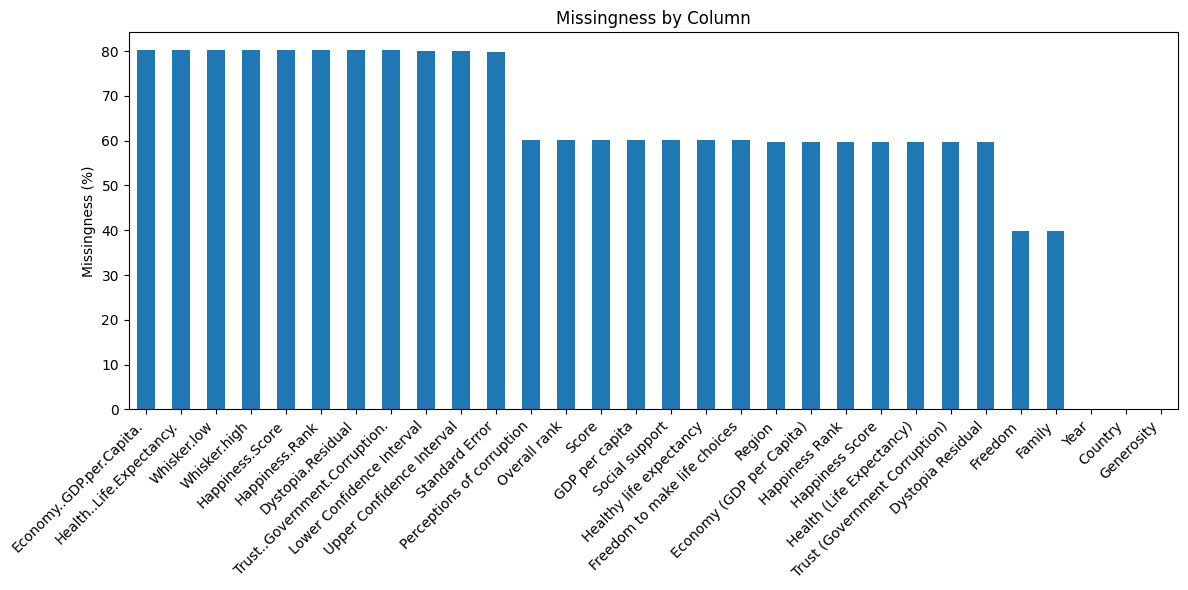

In [81]:
plt.figure(figsize=(12,6))
missing_by_column.plot(kind="bar")
plt.ylabel("Missingness (%)")
plt.title("Missingness by Column")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

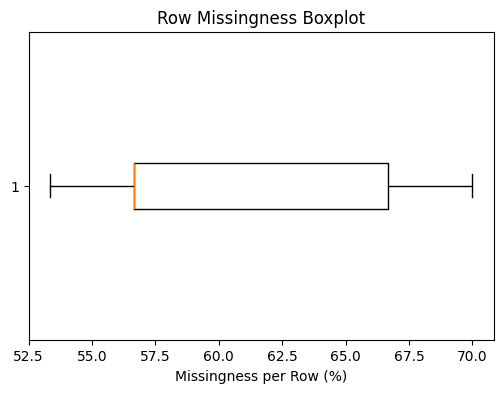

In [83]:
plt.figure(figsize=(6,4))
plt.boxplot(missing_by_row, vert=False)
plt.xlabel("Missingness per Row (%)")
plt.title("Row Missingness Boxplot")
plt.show()

EDA on WDI only

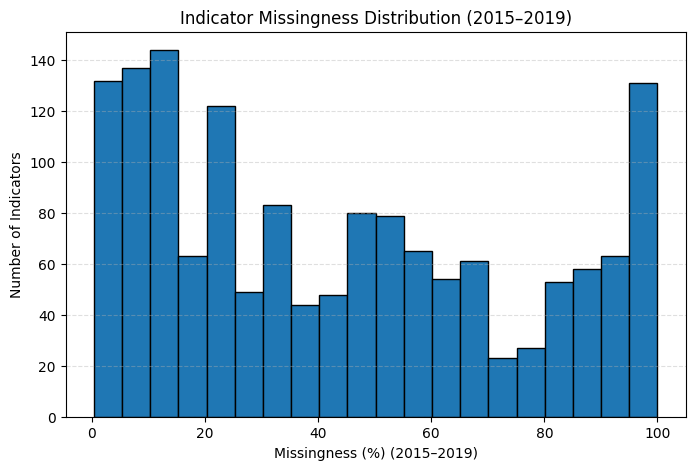

In [84]:
wdi = pd.read_parquet('indicators.parquet', engine='fastparquet')
years = ["2015", "2016", "2017", "2018", "2019"]

wdi["missing_fraction"] = wdi[years].isna().mean(axis=1)

missing_by_indicator = (
    wdi.groupby(["Indicator Code", "Indicator Name"])["missing_fraction"]
      .mean()
      .reset_index(name="avg_missing_frac")
      .sort_values("avg_missing_frac")
)

missing_by_indicator["missing_percent"] = missing_by_indicator["avg_missing_frac"] * 100

plt.figure(figsize=(8,5))
plt.hist(missing_by_indicator["missing_percent"], bins=20, edgecolor="black")
plt.xlabel("Missingness (%) (2015–2019)")
plt.ylabel("Number of Indicators")
plt.title("Indicator Missingness Distribution (2015–2019)")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


EDA on WHR and WDI Together

In [4]:
indicators = pd.read_parquet('indicators.parquet', engine='fastparquet')
happiness = pd.read_parquet('2015.parquet', engine='fastparquet')


In [5]:
indicators.rename(columns={'Country Name': 'country'}, inplace=True)
happiness.rename(columns={'Country': 'country'}, inplace=True)

In [6]:
# creating a subset that only includes countries present in the 2015 happiness dataset
indicators_sample = indicators[indicators['country'].isin(happiness['country'])]
# shrinking down to just 2015 values and filling in missing values via interpolation
years = [str(y) for y in range(2010, 2021)]
year_df = indicators_sample[years].copy()
year_df = year_df.interpolate(axis=1, limit_direction='both')
filled_2015 = year_df['2015']
indicators_sample['value_2015_filled'] = filled_2015

C:\Users\bella\AppData\Local\Temp\ipykernel_16140\1474813957.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indicators_sample['value_2015_filled'] = filled_2015


In [7]:
indicators_sample.rename(columns={'Indicator Name': 'indicator'}, inplace=True)

C:\Users\bella\AppData\Local\Temp\ipykernel_16140\3698729628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indicators_sample.rename(columns={'Indicator Name': 'indicator'}, inplace=True)


In [8]:
indicators_2015 = indicators_sample[['country', 'indicator', 'value_2015_filled']]
happiness_2015 = happiness[['country', "Happiness Score"]]

In [9]:
pivoted = indicators_2015.pivot(index='country', columns='indicator', values='value_2015_filled')
merged = happiness_2015.merge(pivoted, left_on='country', right_index=True)

In [14]:
# fraction of missing values per column
missing_frac = merged.isna().mean().sort_values(ascending=False)

# or percent
missing_percent = missing_frac * 100

completeness = 100 - missing_percent

threshold = 30  # i.e. drop anything with >30% missingness
usable_cols = missing_percent[missing_percent < threshold].index
filtered = merged[usable_cols]

filtered["Happiness Score"] = merged["Happiness Score"]

C:\Users\bella\AppData\Local\Temp\ipykernel_16140\2407612744.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Happiness Score"] = merged["Happiness Score"]


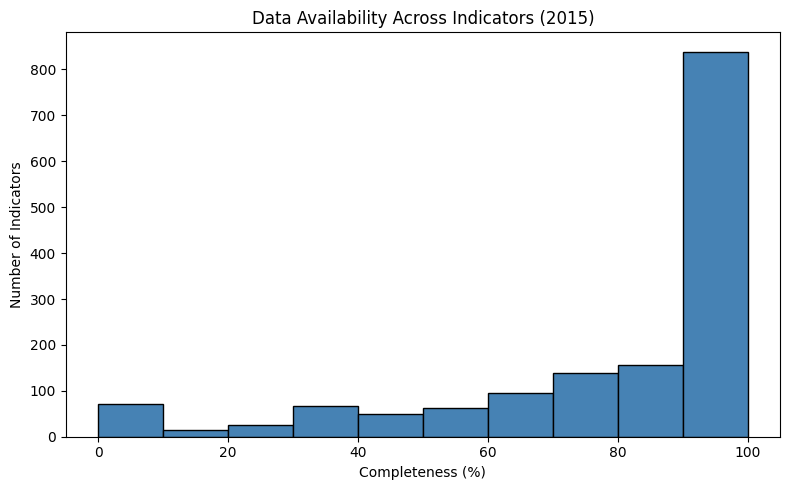

In [15]:
plt.figure(figsize=(8,5))
plt.hist(completeness, bins=np.arange(0, 110, 10), color="steelblue", edgecolor="black")
plt.xlabel("Completeness (%)")
plt.ylabel("Number of Indicators")
plt.title("Data Availability Across Indicators (2015)")
plt.tight_layout()
plt.show()


In [17]:
complete_inds = missing_percent[missing_percent == 0].index.tolist()

constant_cols = [
    col for col in complete_inds
    if merged[col].nunique() <= 1
]
print(f"{len(constant_cols)} indicators are constant across countries.")

0 indicators are constant across countries.


In [18]:
corrs = merged.corr(numeric_only=True)['Happiness Score'].sort_values(ascending=False)

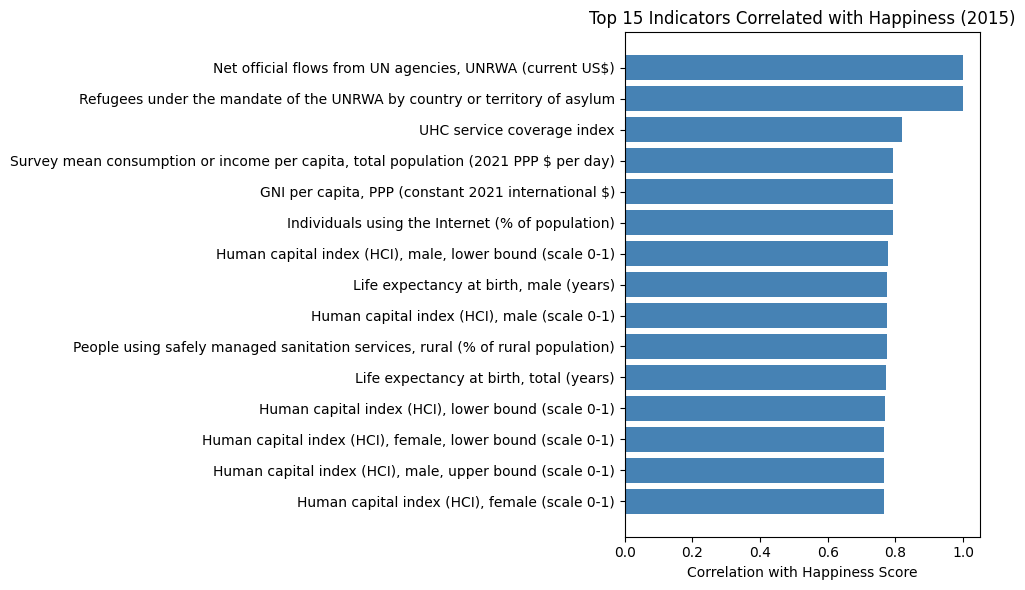

In [19]:
# remove the self-correlation
corrs = corrs.drop("Happiness Score")

# pick top and bottom correlations
top_corrs = corrs.head(15)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.barh(top_corrs.index, top_corrs.values, color="steelblue")
plt.xlabel("Correlation with Happiness Score")
plt.title("Top 15 Indicators Correlated with Happiness (2015)")
plt.gca().invert_yaxis()     # highest correlation at the top
plt.tight_layout()
plt.show()